In [167]:
import os
import datetime
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from IPython.display import Markdown, display

In [168]:
def printmd(string):
    display(Markdown(string))

In [135]:
def load_blinks(subject, cond, num_parts):
    path = '../eye_openess_features/' + subject + '/' + cond + '/'
    all_status_rates = []
    all_wrong_frames = []
    for num in range(1, num_parts+1):
        status_rates = list(np.load(path + "status_rates_part" + str(num) + ".npy"))
        wrong_frames = list(np.load(path + "wrong_frames_part" + str(num) + ".npy"))
        
        all_status_rates = all_status_rates + status_rates
        all_wrong_frames = all_wrong_frames + wrong_frames
    return all_status_rates, all_wrong_frames

In [136]:
# Finds eye-blinks given a sequence of values and a treshhold.
def find_blinks(values, treshhold):
    blink = False
    blinks = []
    blink_count = 0
    for i, val in enumerate(values):
        if val < treshhold:
            if blink == False:
                blink_count +=1
                start = i
            blink = True
        else:
            if blink == True:
                end = i - 1
                #calculate duration of blink, and include in tuple
                duration = end - start + 1
                blinks.append((start, end, duration))
                #print("Blinking period: " + str(start) + " - " + str(end))
            blink = False
    return blinks, blink_count

In [137]:
# Extracts features in a segment from given blinks
def blinks_segment(blink_starts, blink_durs, video_len, segment_len):
    # the amount of frames at the end that are not taken into account
    rest = video_len % segment_len
    num_frames = video_len - rest
    blink_counts = []
    average_durs = []
    
    blink_count = 0
    dur_count = 0
    
    # a blink is counted to a segment,when the blink starts in that segment
    for frame in range(num_frames):
        if frame % 30000 == 0:
            print(frame)
        # only happens at the end of a segment
        if frame % segment_len == 0 and frame != 0:
            #print('new_segment', frame)
            blink_counts.append(blink_count)
            if dur_count > 0:
                avg_dur = dur_count / blink_count
            else:
                avg_dur = 0
            average_durs.append(avg_dur)
            blink_count = 0 
            dur_count = 0
        # happens when a blink starts
        if frame in blink_starts:
            frame_index = blink_starts.index(frame)
            blink_count += 1
            dur_count += blink_durs[frame_index]
            
    return blink_counts, average_durs

In [138]:
status_rates_sleepy, wrong_frames_sleepy = load_blinks('subject1', 'sleepy', 3) 
print("Sleepy number of frames: ", len(status_rates_sleepy))
print("Sleepy missed faces: ", len(wrong_frames_sleepy))
status_rates_normal, wrong_frames_normal = load_blinks('subject1', 'normal', 4) 
print("Normal number of frames: ", len(status_rates_normal))
print("Normal missed faces: ", len(wrong_frames_normal))

Sleepy number of frames:  150002
Sleepy missed faces:  1767
Normal number of frames:  163001
Normal missed faces:  4034


In [139]:
def find_microsleeps(status_rates, threshhold, top_n = 10, fps = 46):
    blinks, count = find_blinks(status_rates, threshhold)
    longest_blinks = sorted(blinks, key=lambda x: x[2], reverse=True)[:top_n]
    blink_starts_sec = list(np.array(longest_blinks)[:, 0] / fps)
    for i in range(top_n):
        print("Top " + str(i + 1) + " : ")
        print("Duration: " + str(longest_blinks[i][2]))
        print("Start : " + str(datetime.timedelta(seconds=blink_starts_sec[i])))
    print(blink_starts_sec[:top_n])
    print(longest_blinks)


find_microsleeps(status_rates_normal, 10, 10, 46)

Top 1 : 
Duration: 124
Start : 0:40:13.043478
Top 2 : 
Duration: 120
Start : 0:39:42.760870
Top 3 : 
Duration: 116
Start : 0:39:28.782609
Top 4 : 
Duration: 93
Start : 0:39:38.956522
Top 5 : 
Duration: 84
Start : 0:40:04.347826
Top 6 : 
Duration: 83
Start : 0:39:26.673913
Top 7 : 
Duration: 74
Start : 0:39:59.043478
Top 8 : 
Duration: 72
Start : 0:39:55.152174
Top 9 : 
Duration: 65
Start : 0:39:31.326087
Top 10 : 
Duration: 60
Start : 0:40:27.108696
[2413.0434782608695, 2382.7608695652175, 2368.782608695652, 2378.9565217391305, 2404.3478260869565, 2366.6739130434785, 2399.0434782608695, 2395.1521739130435, 2371.3260869565215, 2427.108695652174]
[(111000, 111123, 124), (109607, 109726, 120), (108964, 109079, 116), (109432, 109524, 93), (110600, 110683, 84), (108867, 108949, 83), (110356, 110429, 74), (110177, 110248, 72), (109081, 109145, 65), (111647, 111706, 60)]


In [140]:
def run_analysis(status_rates, wrong_frames, treshhold, segment_length):
    blinks, count = find_blinks(status_rates, treshhold)
    print("Number of blinks: ", len(blinks))

    blink_starts = list(np.array(blinks)[:,0])
    blink_durs = list(np.array(blinks)[:,2])

    blink_counts, average_durs = blinks_segment(blink_starts, blink_durs, len(status_rates), segment_length)
    print("Number of segments", len(blink_counts))
    print("Mean blink count per segment", np.mean(blink_counts))
    print("Mean blink duration per segment", np.mean(average_durs))
    return blink_counts, average_durs


def plot_analysis(blink_counts, average_durs, save_counts=False, save_durs=False):
    # Plotting blink counts
    plt.title("Blink counts of a " + str(segment_length) + " frame segment")
    plt.xlabel('Frame segment')
    plt.ylabel('Blink counts')
    plt.plot(range(len(blink_counts)), blink_counts)
    if save_counts != False:
        plt.savefig(save_counts)
    plt.show()

    # Plotting average blink durations
    plt.title("Average blink duration of a frame segment")
    plt.xlabel('Frame segment')
    plt.ylabel('Average blink duration')
    plt.plot(range(len(average_durs)), average_durs)
    if save_durs != False:
        plt.savefig(save_durs)
    plt.show()

Number of blinks:  2545
0
30000
60000
90000
120000
Number of segments 107
Mean blink count per segment 23.317757009345794
Mean blink duration per segment 5.975149446412866


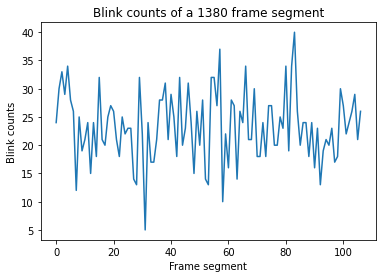

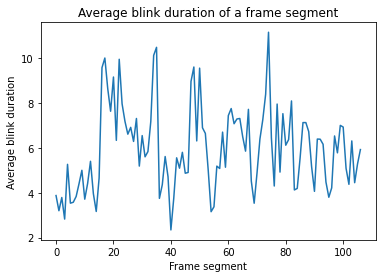

In [155]:
treshhold = 10
segment_length = int(2760 / 2)

blink_counts_sleepy, average_durs_sleepy = run_analysis(status_rates_sleepy, wrong_frames_sleepy, treshhold, segment_length)
plot_analysis(blink_counts_sleepy, average_durs_sleepy)

Number of blinks:  3731
0
30000
60000
90000
120000
150000
Number of segments 117
Mean blink count per segment 31.641025641025642
Mean blink duration per segment 3.505094236377752


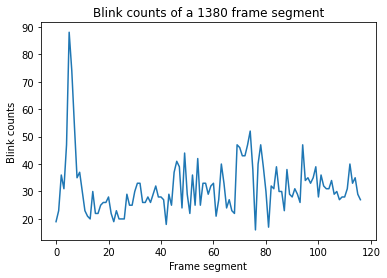

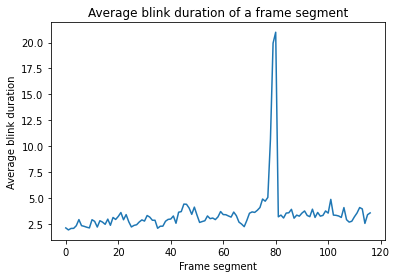

In [156]:
blink_counts_normal, average_durs_normal = run_analysis(status_rates_normal, wrong_frames_normal, treshhold, segment_length)
plot_analysis(blink_counts_normal, average_durs_normal)

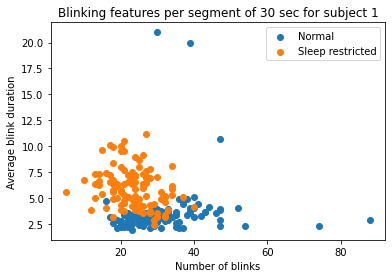

In [157]:
# make a scatter plot of the two classes
plt.title("Blinking features per segment of 30 sec for subject 1")
plt.xlabel("Number of blinks")
plt.ylabel("Average blink duration")
plt.scatter(blink_counts_normal, average_durs_normal, label = 'Normal')
plt.scatter(blink_counts_sleepy, average_durs_sleepy, label = 'Sleep restricted')
plt.legend()
plt.savefig('../figures/scatter_plot_sub1_30sec.jpg')
plt.show()

Mean number of blink frames sleepy:  136.54205607476635
Mean number of blink frames normal:  113.90598290598291


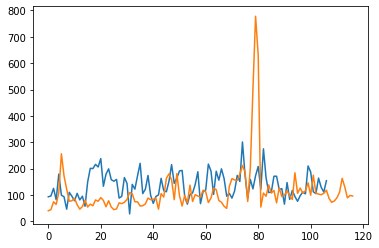

In [158]:
# The number of blinking frames is just a multiplication of the duration and number of blinks
blink_frames_sleepy = list(np.multiply(np.array(blink_counts_sleepy), np.array(average_durs_sleepy)))
blink_frames_normal = list(np.multiply(np.array(blink_counts_normal), np.array(average_durs_normal)))

print("Mean number of blink frames sleepy: ", np.mean(blink_frames_sleepy))
print("Mean number of blink frames normal: ", np.mean(blink_frames_normal))

# Plotting blink frames in one plot.
plt.plot(range(len(blink_frames_sleepy)), blink_frames_sleepy)
plt.plot(range(len(blink_frames_normal)), blink_frames_normal)
plt.show()

In [175]:
def t_test(normal_vals, sleepy_vals):
    print("Var: ", np.var(normal_vals), np.var(sleepy_vals))
    print("Std: ", np.std(normal_vals), np.std(sleepy_vals))
    print("Mean: ", np.mean(normal_vals), np.mean(sleepy_vals))
    t_score = stats.ttest_ind(normal_vals, sleepy_vals, equal_var=False)
    print("T-test P Val ", t_score[1])
    w_score = stats.wilcoxon(normal_vals[:len(sleepy_vals)], sleepy_vals)
    print("Wilcoxon P Val ", w_score[1])
    

printmd("Blink duration")
t_test(average_durs_normal, average_durs_sleepy)

printmd("Blink count")
t_test(blink_counts_normal, blink_counts_sleepy)

printmd("Blink frames")
t_test(blink_frames_normal, blink_frames_sleepy)

Blink duration

Var:  5.89745964750204 3.4826219638058324
Std:  2.4284685807113173 1.8661784383616247
Mean:  3.505094236377752 5.975149446412866
T-test P Val  2.4558779105763555e-15
Wilcoxon P Val  1.6411364833047895e-15


Blink count

Var:  102.65746219592374 37.4130491746004
Std:  10.13200188491513 6.116620731629549
Mean:  31.641025641025642 23.317757009345794
T-test P Val  2.5271712069758483e-12
Wilcoxon P Val  7.591191696755909e-11


Blink frames

Var:  9122.358682153554 2437.1267359594726
Std:  95.51103958262392 49.367263808717134
Mean:  113.90598290598291 136.54205607476635
T-test P Val  0.025981898218562078
Wilcoxon P Val  9.46572235106697e-06


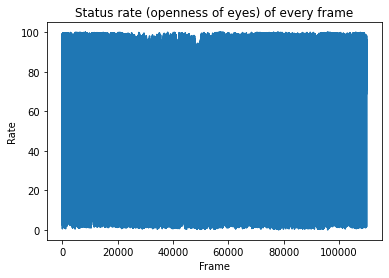

In [73]:
# look at the blinks more in depth
# DONT change these parameters
frame_start = 0
frame_end = len(status_rates)  # normal sleep: last frame is 2804    restricted sleep: last frame is 2774 
frames = range(frame_start, frame_end + 1)

# CHANGE these parameter
frame_start = 0
frame_end = 110000

plt.title("Status rate (openness of eyes) of every frame")
plt.xlabel('Frame')
plt.ylabel('Rate')
plt.plot(frames[frame_start:frame_end], status_rates[frame_start:frame_end])
plt.show()